
=== Model Performance ===
Test Accuracy: 0.9356223175965666
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       116
           1       0.92      0.96      0.94       117

    accuracy                           0.94       233
   macro avg       0.94      0.94      0.94       233
weighted avg       0.94      0.94      0.94       233



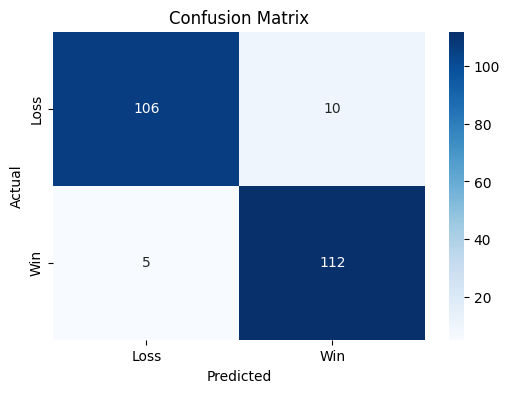

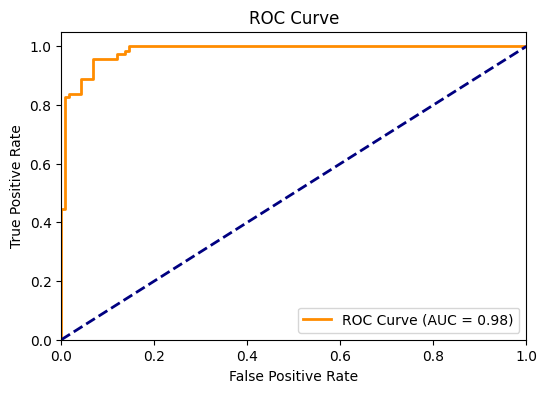


=== Cross-Validation ===
CV Accuracy: 92.81% (±1.20%)


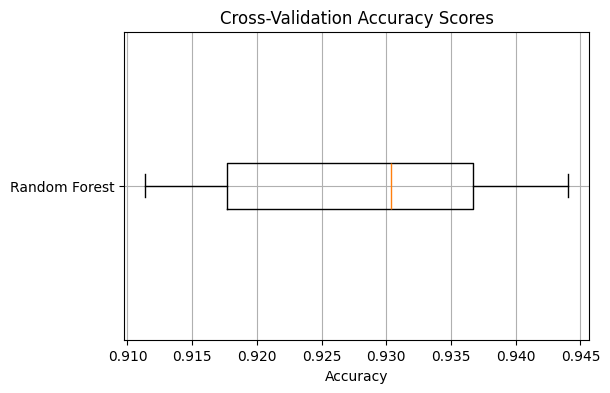


=== Top 10 Features ===
   Feature  Importance
4      KPR    0.284247
3      ADR    0.226599
1      K:D    0.132462
12    KMax    0.059116
6     FKPR    0.057496
16      FK    0.054551
17      FD    0.028166
13       K    0.019549
14       D    0.017872
5      APR    0.017710


C:\Users\putri\AppData\Local\Temp\ipykernel_10160\3679235662.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


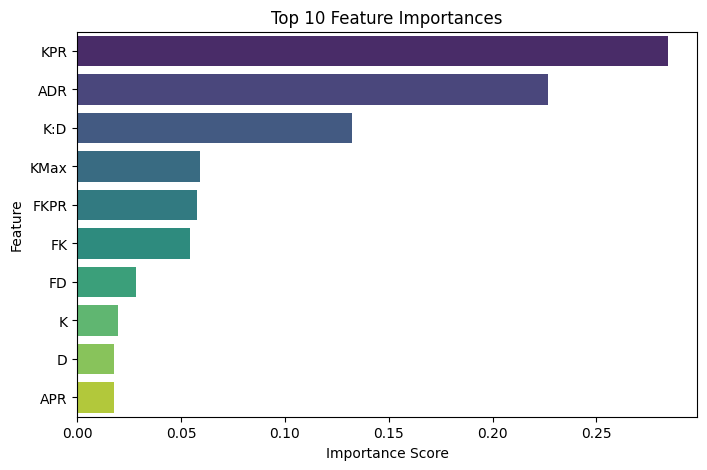


=== Overfitting Check ===
Train Accuracy: 95.76%
Test Accuracy: 93.56%
Gap: 2.19% (should be <5%)


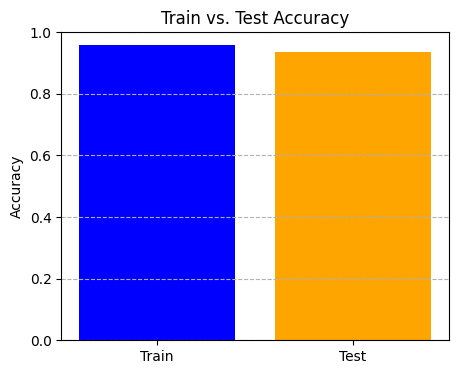

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# --- Load & Preprocess Data ---
data = pd.read_csv('VCT_2024.csv')
drop_cols = ['Region', 'Player', 'Team Abbreviated', 'Event', 'CL', 'R']
data = data.drop(columns=drop_cols)

numeric_cols = ['K:D', 'KAST', 'ADR', 'KPR', 'APR', 'FKPR', 'FDPR', 'HS%', 'CL%', 'CW', 'CP']
data['Win'] = (data['ACS'] >= data['ACS'].median()).astype(int)
y = data['Win']
X = data.drop(columns=['Win', 'ACS'])

# Encode categorical variables
X = pd.get_dummies(X, columns=['Team'], drop_first=True)

# Handle missing values and scale features
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(imputer.fit_transform(X[numeric_cols]))

# Train-test split
groups = data['Team']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Train Random Forest ---
rf_pipeline = make_pipeline(
    RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        min_samples_split=10,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'
    )
)
rf_pipeline.fit(X_train, y_train)

# --- Model Performance ---
y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

print("\n=== Model Performance ===")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 1. Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# --- Cross-Validation ---
cv = GroupKFold(n_splits=5)
cv_scores = cross_val_score(rf_pipeline, X, y, cv=cv, groups=groups)

print("\n=== Cross-Validation ===")
print(f"CV Accuracy: {cv_scores.mean():.2%} (±{cv_scores.std():.2%})")

# 3. Cross-Validation Scores (Boxplot)
plt.figure(figsize=(6, 4))
plt.boxplot(cv_scores, vert=False)
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Accuracy')
plt.yticks([1], ['Random Forest'])
plt.grid(True)
plt.show()

# --- Feature Importance ---
if hasattr(rf_pipeline.steps[-1][1], 'feature_importances_'):
    importances = rf_pipeline.steps[-1][1].feature_importances_
    features = X.columns
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    top_10 = feature_importance.sort_values('Importance', ascending=False).head(10)

    print("\n=== Top 10 Features ===")
    print(top_10)

    # 4. Feature Importance (Bar Plot)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

# --- Overfitting Check ---
train_accuracy = rf_pipeline.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

print("\n=== Overfitting Check ===")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Gap: {abs(train_accuracy - test_accuracy):.2%} (should be <5%)")

# 5. Train vs. Test Accuracy (Bar Plot)
plt.figure(figsize=(5, 4))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.title('Train vs. Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')
plt.show()